In [1]:
# 1) 数据加载与向量化
import os, numpy as np
from pathlib import Path
from tensorflow import keras

NUM_WORDS = 10000
LOCAL_CACHE = Path("./reuters.npz") 

def load_reuters(num_words=NUM_WORDS):
    if LOCAL_CACHE.exists():
        print(f"检测到离线数据文件: {LOCAL_CACHE.resolve()}")
        with np.load(LOCAL_CACHE, allow_pickle=True) as f:
            x_train, y_train = f["x_train"], f["y_train"]
            x_test, y_test   = f["x_test"], f["y_test"]
        # 若存储的是对象数组（list of lists），需确保类型正确
        x_train = [np.array(seq, dtype="int64").tolist() for seq in x_train]
        x_test  = [np.array(seq, dtype="int64").tolist() for seq in x_test]
        return (x_train, y_train), (x_test, y_test)
    else:
        print("未找到离线 reuters.npz，尝试通过 Keras 在线下载（需要联网）...")
        return keras.datasets.reuters.load_data(num_words=num_words)

def vectorize(seqs, dim=NUM_WORDS):
    x = np.zeros((len(seqs), dim), dtype="float32")
    for i, seq in enumerate(seqs):
        # 过滤越界索引，保证鲁棒
        seq = [w for w in seq if 0 <= w < dim]
        x[i, seq] = 1.0
    return x

(x_train_seq, y_train), (x_test_seq, y_test) = load_reuters(NUM_WORDS)
x_train = vectorize(x_train_seq, NUM_WORDS)
x_test  = vectorize(x_test_seq,  NUM_WORDS)

num_classes = int(np.max([y_train.max(), y_test.max()])) + 1
print("训练/测试样本与类别数：", x_train.shape, x_test.shape, num_classes)

# One-Hot 标签（也可改用稀疏版本：sparse_categorical_crossentropy）
y_train_oh = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_oh  = keras.utils.to_categorical(y_test,  num_classes=num_classes)

# 验证集切分
x_val, x_tr = x_train[:1000], x_train[1000:]
y_val, y_tr = y_train_oh[:1000], y_train_oh[1000:]

未找到离线 reuters.npz，尝试通过 Keras 在线下载（需要联网）...
2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step
训练/测试样本与类别数： (8982, 10000) (2246, 10000) 46


In [2]:
# 2) 模型构建
from tensorflow.keras import layers, regularizers

def build_model(units=64, hidden_layers=2, lr=1e-3, dropout=0.2, l2=0.0, input_dim=NUM_WORDS, num_classes=46):
    reg = regularizers.l2(l2) if l2 > 0 else None
    m = keras.Sequential([layers.Input(shape=(input_dim,))])
    for _ in range(hidden_layers):
        m.add(layers.Dense(units, activation="relu", kernel_regularizer=reg))
        if dropout > 0: m.add(layers.Dropout(dropout))
    m.add(layers.Dense(num_classes, activation="softmax"))
    m.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m

model = build_model(units=64, hidden_layers=2, lr=1e-3, dropout=0.2, l2=0.0, input_dim=NUM_WORDS, num_classes=y_train_oh.shape[1])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 46)                  │           2,990 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# 3) 回调：早停、保存最佳、降学习率、TensorBoard
import time
log_dir = f"logs_ann1/{int(time.time())}"
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("ann1_best.keras", monitor="val_loss", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
]
print("TensorBoard 日志目录：", log_dir)

TensorBoard 日志目录： logs_ann1/1762679827


Epoch 1/30
16/16 - 1s - 65ms/step - accuracy: 0.4272 - loss: 2.8976 - val_accuracy: 0.5630 - val_loss: 1.9716 - learning_rate: 0.0010
Epoch 2/30
16/16 - 0s - 14ms/step - accuracy: 0.6163 - loss: 1.7625 - val_accuracy: 0.6690 - val_loss: 1.4758 - learning_rate: 0.0010
Epoch 3/30
16/16 - 0s - 19ms/step - accuracy: 0.6883 - loss: 1.4006 - val_accuracy: 0.7040 - val_loss: 1.2773 - learning_rate: 0.0010
Epoch 4/30
16/16 - 0s - 15ms/step - accuracy: 0.7280 - loss: 1.1934 - val_accuracy: 0.7470 - val_loss: 1.1567 - learning_rate: 0.0010
Epoch 5/30
16/16 - 0s - 15ms/step - accuracy: 0.7677 - loss: 1.0414 - val_accuracy: 0.7520 - val_loss: 1.0865 - learning_rate: 0.0010
Epoch 6/30
16/16 - 0s - 16ms/step - accuracy: 0.7933 - loss: 0.9135 - val_accuracy: 0.7730 - val_loss: 1.0193 - learning_rate: 0.0010
Epoch 7/30
16/16 - 0s - 14ms/step - accuracy: 0.8141 - loss: 0.8101 - val_accuracy: 0.7900 - val_loss: 0.9727 - learning_rate: 0.0010
Epoch 8/30
16/16 - 0s - 12ms/step - accuracy: 0.8340 - loss: 0

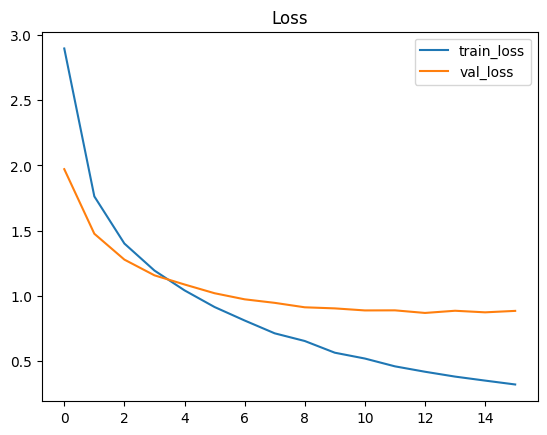

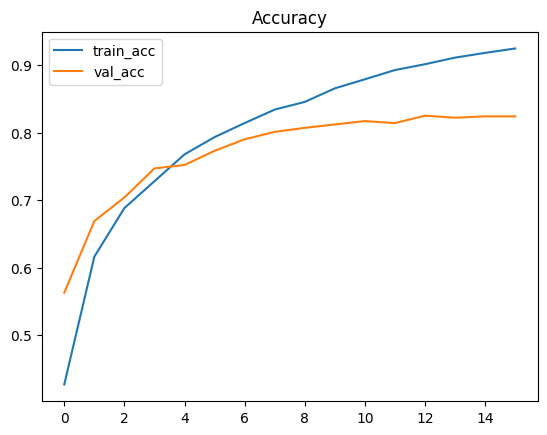

In [4]:
# 4) 训练
history = model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=512,
    callbacks=callbacks,
    verbose=2
)

# 可视化训练曲线
import matplotlib.pyplot as plt
hist = history.history
print("History keys:", hist.keys())

plt.figure()
plt.plot(hist.get("loss", []), label="train_loss")
plt.plot(hist.get("val_loss", []), label="val_loss")
plt.title("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist.get("accuracy", []), label="train_acc")
plt.plot(hist.get("val_accuracy", []), label="val_acc")
plt.title("Accuracy")
plt.legend()
plt.show()

In [5]:
# 5) 在训练+验证上短轮次重训，然后测试
final_model = build_model(units=64, hidden_layers=2, lr=1e-3, dropout=0.2, input_dim=NUM_WORDS, num_classes=y_train_oh.shape[1])
final_model.fit(x_train, y_train_oh, epochs=9, batch_size=512, verbose=2)
test_loss, test_acc = final_model.evaluate(x_test, y_test_oh, verbose=0)
print(f"[FINAL] test_acc={test_acc:.4f}, test_loss={test_loss:.4f}")

Epoch 1/9
18/18 - 0s - 22ms/step - accuracy: 0.4639 - loss: 2.7148
Epoch 2/9
18/18 - 0s - 5ms/step - accuracy: 0.6493 - loss: 1.6101
Epoch 3/9
18/18 - 0s - 5ms/step - accuracy: 0.7094 - loss: 1.2950
Epoch 4/9
18/18 - 0s - 5ms/step - accuracy: 0.7481 - loss: 1.1085
Epoch 5/9
18/18 - 0s - 5ms/step - accuracy: 0.7821 - loss: 0.9618
Epoch 6/9
18/18 - 0s - 4ms/step - accuracy: 0.8093 - loss: 0.8443
Epoch 7/9
18/18 - 0s - 5ms/step - accuracy: 0.8306 - loss: 0.7381
Epoch 8/9
18/18 - 0s - 4ms/step - accuracy: 0.8505 - loss: 0.6607
Epoch 9/9
18/18 - 0s - 4ms/step - accuracy: 0.8640 - loss: 0.5805
[FINAL] test_acc=0.7809, test_loss=0.9640


              precision    recall  f1-score   support

           0      0.833     0.417     0.556        12
           1      0.603     0.867     0.711       105
           2      0.778     0.700     0.737        20
           3      0.937     0.936     0.937       813
           4      0.803     0.905     0.851       474
           5      0.000     0.000     0.000         5
           6      0.833     0.714     0.769        14
           7      0.000     0.000     0.000         3
           8      0.600     0.711     0.651        38
           9      0.818     0.720     0.766        25
          10      0.743     0.867     0.800        30
          11      0.638     0.807     0.713        83
          12      0.000     0.000     0.000        13
          13      0.548     0.622     0.582        37
          14      0.000     0.000     0.000         2
          15      0.000     0.000     0.000         9
          16      0.714     0.758     0.735        99
          17      1.000    

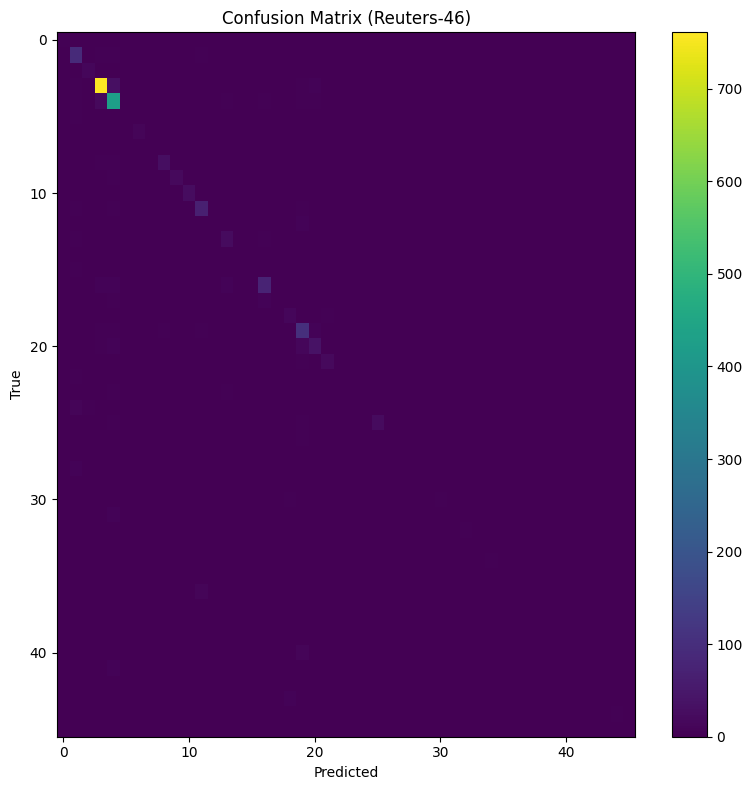

In [7]:
# === #6) 评价：分类报告与混淆矩阵（兼容 one-hot / 稀疏标签）===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# 1) 预测为类别索引
y_pred = final_model.predict(x_test, verbose=0).argmax(axis=1)

# 2) 取 y_true（优先从 one-hot 推断；否则用稀疏整数标签）
if "y_test_oh" in globals():
    y_true = np.argmax(y_test_oh, axis=1)
elif "y_test" in globals():
    y_true = y_test if y_test.ndim == 1 else np.argmax(y_test, axis=1)
else:
    raise RuntimeError(
        "未找到测试集标签（y_test_oh 或 y_test）。请确认前面单元格已运行。"
    )

# 3) 打印报告（避免未命中类别导致 precision 为 NaN 的告警）
print(classification_report(y_true, y_pred, digits=3, zero_division=0))
macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"Macro-F1 = {macro_f1:.4f}")

# 4) 混淆矩阵（固定 46 类顺序；若你改了 num_words 或类别数，可改这里的 labels）
num_classes = getattr(final_model, "output_shape", [None, 46])[-1] or 46
labels_full = list(range(num_classes))  # [0..45]
cm = confusion_matrix(y_true, y_pred, labels=labels_full)

plt.figure(figsize=(8, 8))
plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix (Reuters-46)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()